<a href="https://colab.research.google.com/github/wesleyklhk/tensorflow_notes/blob/main/Listwise_Toy_Example_with_Ragged_Tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q tensorflow-ranking

     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 511.7 MB 4.8 kB/s 
     |████████████████████████████████| 438 kB 40.7 MB/s 
     |████████████████████████████████| 5.8 MB 42.8 MB/s 
     |████████████████████████████████| 1.6 MB 56.0 MB/s 
     |████████████████████████████████| 141 kB 5.1 MB/s 


#Packages Version

In [ ]:
!pip freeze

absl-py==1.2.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.0
click==7.1.2
clikit==0.6.2
cloudpickle==1.3.0
cmake==3.22.5
cmdstanpy==1.0.4
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy=

# Import Packages

In [3]:
import tensorflow as tf
import pprint

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs
from tensorflow_ranking import utils
tf.random.set_seed(1123)


num_observ = 10_000
num_cols = 20

product_eligibility = {
  1:['B', 'D', 'E'],
  2:['B', 'E'],
  3:['A', 'D', 'E'],
  4:['A', 'B', 'C', 'D'],
  5:['A', 'B', 'C', 'E'],
  6:['A', 'B', 'D'],
  7:['A', 'C', 'D', 'E'],
  8:['A', 'B', 'C', 'D', 'E'],    
}
unique_products = ['A', 'B', 'C', 'D', 'E']


# Characters
1. God, who knows everything about the dataset including the data generating mechanisms
2. Data Scientist, who is given a dataset and is required to build a model to predict product preference for unknown customers

# Problem
Given a dataset with the following structure:
<table>
  <thead>
    <tr>
      <td>user_id</td>
      <td>x0</td>
      <td>...</td>
      <td>...</td>
      <td>x9</td>
      <td>...</td>
      <td>xcat</td>
      <td>Product Preference</td>
    </tr>
  </thead>
      <tr>
        <td>user1</td>
        <td>0.11</td>
        <td>...</td>
        <td>...</td>
        <td>0.39</td>
        <td>...</td>
        <td>Type 8</td>
        <td>A < C < B < E < D</td>
    </tr>
      <tr>
        <td>user2</td>
        <td>0.31</td>
        <td>...</td>
        <td>...</td>
        <td>0.71</td>
        <td>...</td>
        <td>Type 1</td>
        <td>D < B < E</td>
    </tr>    
</table>
where
<br>xcat = {type1,type2,...,type8}      
<br>xcat==type1 eligible for ['B', 'D', 'E']
<br>xcat==type2 eligible for ['B', 'E']
<br>xcat==type3 eligible for ['A', 'D', 'E']
<br>xcat==type4 eligible for ['A', 'B', 'C', 'D']
<br>xcat==type5 eligible for ['A', 'B', 'C', 'E']
<br>xcat==type6 eligible for ['A', 'B', 'D']
<br>xcat==type7 eligible for ['A', 'C', 'D', 'E']
<br>xcat==type8 eligible for ['A', 'B', 'C', 'D', 'E']

<br><strong>GOAL</strong>: Our goal here is to rank the products for each customer.
<br><strong>In the data scientist's view</strong>, he/she does not know how that Product Preference come from. All he/she knows are the x0...,xcat.
<br>
<br><strong>In god's view,</strong> he/she knows that the preference is related by the following:
<br>x0,x1 is related to Product A
<br>x2,x3 is related to Product B
<br>x4,x5 is related to Product C
<br>x6,x7 is related to Product D
<br>x8,x9 is related to Product E
<br>And that the product score is computed as $ tanh((x_{i} - x_{i-1})^{2}) $
<br>E.g. Product D score = $ tanh((x_{7} - x_{6})^{2}) $
<br>The order among the products are governed by the magnitude of the product score
<br>E.g. User999 has the following product scores:
<table>
  <thead>
    <tr>
      <td>A</td>
      <td>B</td>
      <td>C</td>
      <td>D</td>
      <td>E</td>
    </tr>
  </thead>
    <tr>
      <td>0.71</td>
      <td>0.23</td>
      <td>-0.56</td>
      <td>-0.12</td>
      <td>1.53</td>
    </tr>  
</table>
Hence, the preference would be C < D < B < A < E

<strong>Problem:</strong>
<br>Formally, the goal of the data scientist is as follows:
<br>Given x0...xcat, predict the product preference

# Generate Synthetic Dataset [Created by God]

## Create Raw X

In [5]:
def generate_raw_X(num_observ,num_cols):
  _df = pd.DataFrame(np.random.rand(num_observ,num_cols),
                     columns=[f'x{i}' for i in range(num_cols)])
  _df['xcat'] = np.random.choice( 1+np.arange(8),num_observ )
  _df['xcat'] = 'type'+_df['xcat'].astype('str')
  _df.index.name = 'user_id'
  return _df
Xtrain_df = generate_raw_X(num_observ,num_cols)
Xval_df = generate_raw_X(num_observ,num_cols)
Xtes_df = generate_raw_X(num_observ,num_cols)

Xtrain_df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,x17,x18,x19,xcat
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.157751,0.640111,0.241659,0.582573,0.333581,0.977945,0.829912,0.918818,0.801844,0.640333,...,0.234417,0.711535,0.734214,0.993438,0.404218,0.799319,0.320528,0.877949,0.290977,type3
1,0.559562,0.586579,0.762149,0.487868,0.582925,0.123289,0.946043,0.837626,0.710112,0.024854,...,0.731937,0.331981,0.852197,0.722136,0.126628,0.053703,0.610438,0.035694,0.068798,type2
2,0.585325,0.423605,0.463311,0.974175,0.446163,0.420336,0.517581,0.940832,0.199490,0.606149,...,0.002562,0.020379,0.251622,0.546819,0.762803,0.242445,0.634788,0.404682,0.683973,type1
3,0.161732,0.505523,0.771300,0.543218,0.957827,0.687034,0.475002,0.823363,0.612514,0.679778,...,0.009403,0.770003,0.906821,0.930266,0.504848,0.656449,0.429880,0.041753,0.211846,type5
4,0.964914,0.301002,0.644773,0.294721,0.900495,0.095516,0.282339,0.272226,0.796685,0.048425,...,0.828507,0.989138,0.998884,0.291989,0.668539,0.903470,0.114619,0.887837,0.674822,type2


## Create Product Preference

In [11]:
def product_score_func(_df):
  _sc = pd.DataFrame({
    p:np.tanh((_df[f'x{i+1}'] - _df[f'x{i}'])**2) 
    for i,p in enumerate(['A','B','C','D','E'])      
  })
  _sc.index = _df.index
  return _sc
Xtrain_score_df = product_score_func(Xtrain_df)
Xval_score_df = product_score_func(Xval_df)    
Xtes_score_df = product_score_func(Xtes_df)    

Xtrain_score_df.tail()

,A,B,C,D,E
user_id,,,,,
9995,0.693450,0.140880,0.261460,0.152647,0.063647
9996,0.275328,0.183259,0.024866,0.046275,0.040963
9997,0.032703,0.010549,0.030459,0.135315,0.627999
9998,0.300837,0.209944,0.507457,0.054380,0.121005
9999,0.035870,0.007098,0.370996,0.167618,0.127520


In [10]:
def rank_score(_df,_score_df):
  dfs = []
  for i,v in product_eligibility.items():
    typei_users = _df.query(f'xcat=="type{i}" ')
    typei_scores = _score_df.loc[typei_users.index]
    non_eligible_products = list(set(unique_products) - set(v))
    typei_scores[non_eligible_products] = np.nan
    typei_rank = typei_scores.rank(method='first',ascending=True,axis=1)
    dfs.append(typei_rank)
  return pd.concat(dfs).sort_index()
train_rank_df = rank_score(Xtrain_df,Xtrain_score_df)
val_rank_df = rank_score(Xval_df,Xval_score_df)
tes_rank_df = rank_score(Xtes_df,Xtes_score_df)
train_rank_df.tail()

,A,B,C,D,E
user_id,,,,,
9995,4.0,1.0,3.0,2.0,NaN
9996,4.0,3.0,1.0,NaN,2.0
9997,3.0,1.0,2.0,4.0,NaN
9998,NaN,2.0,NaN,NaN,1.0
9999,2.0,1.0,4.0,3.0,NaN


Up to this point, we have created a dataframe indicating the ranking of each product. Lets looks at the following example:
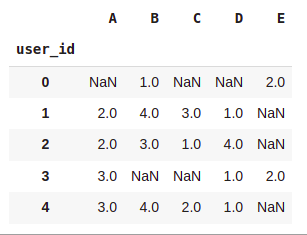

<br>For user_id=0, its product preference is B < E
<br>For user_id=2, its product preference is C < A < B < D
<br>For user_id=4, its product preference is D < C < A < B

<br>
<br>
<br>
<strong>Up to this point, all these data elements are prepared by God. In the next section, we will be taking these elements to prepare dataset which is suitably consumed by our Listwise Neural Network Model</strong>

# Data Preprocessing [Conducted by Data Scientist]

What are available datasets?
<br>
<table>
  <tr>
    <td>Datasets Given to the Data Scientist</td>
    <td>Datasets Created by the Data Scientist</td>
    <td>Datasets Consumed by the Model</td>
  </tr>
  <tr>
    <td>
      <ol>
        <li>
          <Strong>Raw X</Strong>
          <br>Xtrain_df
          <br>Xval_df
          <br>Xtes_df        
        </li>
        <li>
          <Strong>Rank df (a.k.a Product Preference)</Strong>
          <br>train_rank_df
          <br>val_rank_df
          <br>tes_rank_df        
        </li>        
      </ol>
    </td>
    <td>N/A</td>
    <td>N/A</td>
  </tr>
</table>


In [12]:
def rank_v2(_df):
  _min_rank = int(_df.min().min())
  _max_rank = int(_df.max().max())

  _res = pd.DataFrame({f'rank{i}':np.select(
      condlist=[(_df==i).sum(axis=1)==1],
      choicelist=[(_df==i).idxmax(axis=1)],
      default=np.NaN
  ) for i in range(_min_rank,_max_rank+1)})
  _res.index = _df.index
  return _res

train_rank2_df = rank_v2(train_rank_df)
val_rank2_df = rank_v2(val_rank_df)
tes_rank2_df = rank_v2(tes_rank_df)

train_rank2_df.tail()

,rank1,rank2,rank3,rank4,rank5
user_id,,,,,
9995,B,D,C,A,NaN
9996,C,E,B,A,NaN
9997,B,C,A,D,NaN
9998,E,B,NaN,NaN,NaN
9999,B,A,D,C,NaN


The rank_df created by god can be expressed in another way where the columns become the ranking.
Lets look at the following example:<br>
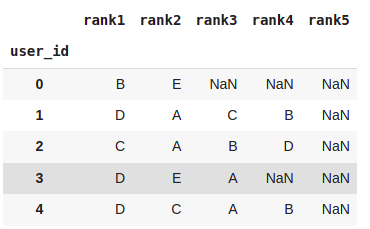

<br>For user_id=0, its product preference is B < E
<br>For user_id=2, its product preference is C < A < B < D
<br>For user_id=4, its product preference is D < C < A < B


In [15]:
def denom(_df):
  return pd.concat([
      _df[[col]].rename(columns={col:'_value'}).assign(_column=col) 
      for col in _df.columns
  ])
colren = {'_column':'_rank','_value':'product'}
denom_train_rank_df = denom(train_rank2_df).rename(columns=colren)
denom_train_rank_df['_rank'] = denom_train_rank_df['_rank'].str.replace('rank','').astype('float')
denom_val_rank_df = denom(val_rank2_df).rename(columns=colren)
denom_val_rank_df['_rank'] = denom_val_rank_df['_rank'].str.replace('rank','').astype('float')
denom_tes_rank_df = denom(tes_rank2_df).rename(columns=colren)
denom_tes_rank_df['_rank'] = denom_tes_rank_df['_rank'].str.replace('rank','').astype('float')
denom_train_rank_df.sort_index().head(10)


,product,_rank
user_id,,
0,D,1.0
0,NaN,4.0
0,NaN,5.0
0,A,2.0
0,E,3.0
1,NaN,5.0
1,NaN,3.0
1,NaN,4.0
1,B,1.0


The rank_df created by god can be expressed in another way where the columns become the ranking.
Lets look at the following example:<br>
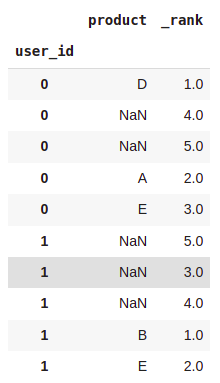
<br> This denormalized form allows us to do dataframe joining easily based on products or ranking which can be useful when doing evaluation and preparing tensorflow dataset

In [16]:
Xtrain_df.sort_index(inplace=True)
Xval_df.sort_index(inplace=True)
Xtes_df.sort_index(inplace=True)

# Building Tensorflow Dataset [Conducted by Data Scientist]

What are available datasets?
<br>
<table>
  <tr>
    <td>Datasets Given to the Data Scientist</td>
    <td>Datasets Created by the Data Scientist</td>
    <td>Datasets Consumed by the Model</td>
  </tr>
  <tr>
    <td>
      <ol>
        <li>
          <Strong>Raw X</Strong>
          <br>Xtrain_df
          <br>Xval_df
          <br>Xtes_df        
        </li>
        <li>
          <Strong>Rank df (a.k.a Product Preference)</Strong>
          <br>train_rank_df
          <br>val_rank_df
          <br>tes_rank_df        
        </li>        
      </ol>
    </td>
    <td>
      <ol>
        <li>
          <Strong>rank2_df (Col names are rankings)</Strong>
          <br>train_rank2_df
          <br>val_rank2_df
          <br>tes_rank2_df        
        </li>
        <li>
          <Strong>Long dataframe with 2 major columns namely, _rank and product</Strong>
          <br>denom_train_rank_df
          <br>denom_val_rank_df
          <br>denom_tes_rank_df        
        </li>        
      </ol>
    </td>
    <td>N/A</td>
  </tr>
</table>


Up to this point, we have 3 major types of dataset:
1. Xtrain_df (which contains the numeric features prepared by god) <strong>[1 row = 1 user_id = 1 observation]</strong>
2. denom_train_rank_df (this dataset contains the rank across products for each user_id but span multiple rows prepared by Data Scientist) <strong>[N rows = 1 user_id = 1 observation]</strong>
3. train_rank2_df (this dataset contains the rank across products for each user_id but only occupies 1 row prepared by data scientist) <strong>[1 row = 1 user_id = 1 observation]</strong>

Note: type2(long dataframe) has an irregular shape<br>
E.g. Sometimes, 1 user_id occupies 3 rows, sometimes occupies 4 rows, sometimes occupies 5 rows
<br>This irregular shape will eventually be a problem when training.
<br>As you will see later on in the model architecture section, we will be using ragged=True parameter in the listwise and ndcg.
Lets prepare the tensorflow dataset first
For these irregular shape items, we will be padding them so that they become a regular shape
<br>E.g. user_id 67 is only eligible for A C D E
<br>his products become ["A","C","D","E","\<NA\>"]
<br>his products ranking become [1,2,4,3,-99]


In [17]:
from pprint import pprint

# _X_df,_denom_rank_df,_rank2_df = Xtrain_df,denom_train_rank_df,train_rank2_df
def tfd_prepare(_X_df,_denom_rank_df,_rank2_df):
  unique_indexes = _rank2_df.index.unique()
  X_con = _X_df.select_dtypes('float').loc[unique_indexes]
  rowlens = pd.notnull(_rank2_df).sum(axis=1).loc[unique_indexes]
  product = _rank2_df.fillna('<NA>')
  product_long = denom(product).sort_values(['user_id','_column']).loc[unique_indexes]._value
  product_rank = pd.notnull(_rank2_df).astype('int').replace(0,np.nan).rank(axis=1,method='first').fillna(-99)
  product_rank_long = denom(product_rank).sort_values(['user_id','_column']).loc[unique_indexes]._value
  tfd_prod = tf.data.Dataset.from_tensor_slices({
      'product':product_long,'_rank':product_rank_long
  }).batch(5)

  tfd_X = tf.data.Dataset.from_tensor_slices({
      'X_con':X_con,
      'X_cat':_X_df.select_dtypes('object').loc[unique_indexes].xcat,
      'X_cus':_X_df.assign(user_id=_X_df.index).loc[unique_indexes].user_id,
      'rowlens':rowlens
  })
  def mapfn(_x,_prod):
    res = _x
    res.update(_prod)
    return res

  return tf.data.Dataset.zip((tfd_X,tfd_prod)).map(mapfn)

tfd_train = tfd_prepare(Xtrain_df,denom_train_rank_df,train_rank2_df)
tfd_val = tfd_prepare(Xval_df,denom_val_rank_df,val_rank2_df)
tfd_tes = tfd_prepare(Xtes_df,denom_tes_rank_df,tes_rank2_df)

for i,v in enumerate(tfd_train.batch(2).take(3)):
  print("*"*10,f'observation{i+1} [START]',"*"*10)
  pprint(v)
  print("*"*10,f'observation{i+1} [END]',"*"*10)
  print()


********** observation1 [START] **********
{'X_cat': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'type3', b'type2'], dtype=object)>,
 'X_con': <tf.Tensor: shape=(2, 20), dtype=float64, numpy=
array([[0.15775059, 0.64011066, 0.2416591 , 0.58257296, 0.33358136,
        0.97794525, 0.82991159, 0.91881822, 0.80184442, 0.64033253,
        0.24698026, 0.23441729, 0.71153484, 0.7342138 , 0.99343753,
        0.40421809, 0.79931872, 0.32052839, 0.87794922, 0.29097686],
       [0.55956201, 0.58657855, 0.76214945, 0.48786782, 0.58292549,
        0.12328936, 0.94604273, 0.83762644, 0.71011205, 0.02485425,
        0.20769132, 0.73193718, 0.3319807 , 0.85219747, 0.72213618,
        0.12662842, 0.0537029 , 0.61043808, 0.03569367, 0.06879771]])>,
 'X_cus': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 '_rank': <tf.Tensor: shape=(2, 5), dtype=float64, numpy=
array([[  1.,   2.,   3., -99., -99.],
       [  1.,   2., -99., -99., -99.]])>,
 'product': <tf.Tensor: shape=(2, 5), dtype

In the code above, we have defined a function for preparing a tensorflow dataset based on our raw X dataframe (from God), denom preference dataframe (from us, data scientist) and rank2_dataframe (col names are rank also from us). The output tensorflow dataset consists of the following components:
1. X_cat (xcat column)
2. X_con (all the continous X columns)
3. X_cus (user_id for tracking purpose)
4. _rank (product ranking higher the ranking means higher the preference)
5. product (product)
6. rowlens (the number of eligible products; this column will be extremely useful when using the ragged=True parameter in Listwiseloss)


# Model Building [Conducted by Data Scientist]
We will modify the RankingModel architecture provided in https://www.tensorflow.org/recommenders/examples/listwise_ranking

In [20]:
unique_xcat = [f'type{i+1}' for i in range(8)]

We would like to build a model which can ride on the ragged=True parameter in ListMLELoss and NDCGMetric with some continuous features and categorical features. We have incorporated normalization layer for x0... and an embedding layer for xcat. 

1. One learning here is that the normalization layer needs to be "adapted" before compiling the model

In [18]:
from tensorflow.keras import regularizers

class RankingModelV2(tfrs.Model):

  def __init__(self, loss,ragged=True):
    super().__init__()

    # Compute embeddings for movies.
    self.xcat_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_xcat),
      tf.keras.layers.Embedding(len(unique_xcat) + 2, 4)
    ])


    # Compute embeddings for product.
    self.product_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_products),
      tf.keras.layers.Embedding(len(unique_products) + 2, 4)
    ])

    self.norm_layer = tf.keras.layers.Normalization(axis=-1)

    # Compute predictions.
    self.score_model = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu",
                            kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                            bias_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
                            ),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation="relu",
                            kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                            bias_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
                            ),
      tf.keras.layers.Dropout(0.5),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
    ])

    self.task = tfrs.tasks.Ranking(
      loss=loss,
      metrics=[
        tfr.keras.metrics.NDCGMetric(name="ndcg_metric",ragged=ragged),
        tf.keras.metrics.RootMeanSquaredError()
      ]
    )

  def call(self, features):
    print(features)

    
    
    # We first convert the id features into embeddings.
    # User embeddings are a [batch_size, embedding_dim] tensor.
    product_embeddings = self.product_embeddings(features["product"])
    xcat_embeddings = self.xcat_embeddings(features["X_cat"])
    print('xcat_embeddings',xcat_embeddings.shape)


    # Movie embeddings are a [batch_size, num_movies_in_list, embedding_dim]
    # tensor.
    norm_con_feats = self.norm_layer(features['X_con'])

    # We want to concatenate user embeddings with movie emebeddings to pass
    # them into the ranking model. To do so, we need to reshape the user
    # embeddings to match the shape of movie embeddings.
    list_length = tf.shape(features["product"])[1]

    
    print('product_embeddings',product_embeddings.shape)
    print('product',features["product"].shape)
    print('norm_con_feats',norm_con_feats.shape)
    print('tf.expand_dims(norm_con_feats, 1)',tf.expand_dims(norm_con_feats, 1).shape)
    
    concatenated_embeddings1 = tf.concat(
        [norm_con_feats, xcat_embeddings], 1)
    print('concatenated_embeddings1',concatenated_embeddings1.shape)

    norm_con_feats_repeated = tf.repeat(
        tf.expand_dims(concatenated_embeddings1, 1), [list_length], axis=1)
    print('norm_con_feats_repeated',norm_con_feats_repeated.shape)

    # Once reshaped, we concatenate and pass into the dense layers to generate
    # predictions.
    concatenated_embeddings = tf.concat(
        [norm_con_feats_repeated, product_embeddings], 2)
    print('concatenated_embeddings',concatenated_embeddings.shape)

    _score = self.score_model(concatenated_embeddings)#norm_con_feats_repeated#
    print('_score',_score.shape)
    return _score

  def compute_loss(self, features, training=False):
    labels = features.pop("_rank")
    rowlens = features['rowlens']

    scores = self(features)
    print('scores',scores.shape)
    print('labels',labels.shape)
    print('tf.squeeze(scores, axis=-1)',tf.squeeze(scores, axis=-1).shape)

    labels_ragged = tf.RaggedTensor.from_tensor(labels,lengths=rowlens)
    scores_ragged = tf.RaggedTensor.from_tensor(tf.squeeze(scores, axis=-1),lengths=rowlens)
    print('scores_ragged',scores_ragged.shape)
    print('labels_ragged',labels_ragged.shape)

    return self.task(
        labels=labels_ragged,
        predictions=scores_ragged,
    )

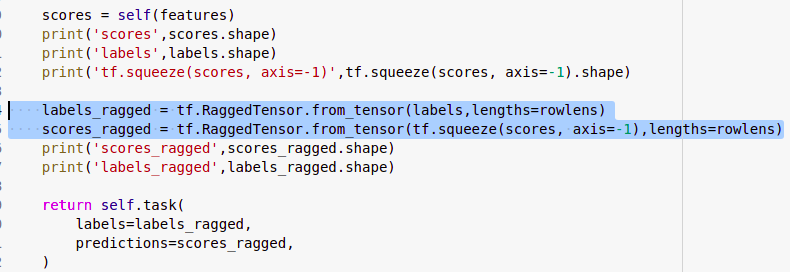
<br>Our "scores" and "labels" are originally regular matrix because of the padding of \<NA\> and -99
<br>Converting these regular matrix with the help of "rowlens", tensorflow will ignore theses padded entries since they all occured at the end of each row. 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',patience=10,mode='min')

listwise_model = RankingModelV2(tfr.keras.losses.ListMLELoss(ragged=True),ragged=True)
listwise_model.norm_layer.adapt(tfd_train.batch(1024).map(lambda x: x['X_con']) )
listwise_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))
# listwise_model.fit(tfd_train.batch(1024),epochs=200,verbose=True)
listwise_model.fit(tfd_train.batch(1024),epochs=800,verbose=True,
                   callbacks=[es],validation_data=tfd_val.batch(1024))



Epoch 1/800
10/10 [==============================] - 2s 182ms/step - ndcg_metric: 0.8524 - root_mean_squared_error: 2.3340 - loss: 3.0044 - regularization_loss: 0.0301 - total_loss: 3.0345 - val_ndcg_metric: 0.8360 - val_root_mean_squared_error: 2.3388 - val_loss: 3.0378 - val_regularization_loss: 0.0301 - val_total_loss: 3.0679
Epoch 2/800
10/10 [==============================] - 2s 226ms/step - ndcg_metric: 0.8530 - root_mean_squared_error: 2.3333 - loss: 3.0039 - regularization_loss: 0.0301 - total_loss: 3.0341 - val_ndcg_metric: 0.8366 - val_root_mean_squared_error: 2.3382 - val_loss: 3.0374 - val_regularization_loss: 0.0301 - val_total_loss: 3.0675
Epoch 3/800
10/10 [==============================] - 2s 225ms/step - ndcg_metric: 0.8535 - root_mean_squared_error: 2.3324 - loss: 3.0035 - regularization_loss: 0.0301 - total_loss: 3.0336 - val_ndcg_metric: 0.8371 - val_root_mean_squared_error: 2.3372 - val_loss: 3.0370 - val_regularization_loss: 0.0301 - val_total_loss: 3.0672
Epoch 4

KeyboardInterrupt: ignored

# Quick Model Evaluation [Conducted by Data Scientist]

Evaluating the ndcg with the test set

In [24]:
listwise_model.evaluate(tfd_tes.batch(128),verbose=True)

79/79 [==============================] - 1s 9ms/step - ndcg_metric: 0.9907 - root_mean_squared_error: 21.8722 - loss: 0.9027 - regularization_loss: 0.0492 - total_loss: 0.9519


[0.990725576877594,
 21.87224578857422,
 1.0814249515533447,
 0.04919156804680824,
 1.130616545677185]

The NDCG performance in the test set is similar to those of validation and training.

# Helper Functions for Evaluation [Conducted by Data Scientist]
This section is to define some helper functions which help us in the model evaluation.

## to_int_series(_series)
<table>
  <tr>
    <td><strong>Function Name:</strong></td>
    <td>to_int_series(_series)</td>
  </tr>
  <tr>
    <td><strong>Input Parameters:</strong></td>
    <td>
      <table>
        <tr>
          <td> _series </td>
          <td> Input series to be converted into integers  </td>
        </tr>
      </table>
    </td>
  </tr>
  <tr>
    <td><strong>Outputs:</strong></td>
    <td>
      <table>
        <tr>
          <td> converted_series </td>
          <td> This is the resultant series after using </td>
        </tr>
        <tr>
          <td> fw_map </td>
          <td> This is a dictionary of mapping from unique string to integer. It is used to generate the converted_series  </td>
        </tr>
        <tr>
          <td> bw_map </td>
          <td> This is a reverse dictionary of mapping from integer to string. </td>
        </tr>                
      </table>
    </td>
    <td>    
  </tr> 
  <tr>
    <td><strong>Description:</strong></td>
    <td>This function is used to convert a series of any datatype(mostly string) into integer series. You can treat this as a homemade LabelEncoder in sklearn. The real reason for using this instead of LabelEncoder is because LabelEncoder cannot handle nan. </td>
  </tr>  
</table>

In [ ]:
def to_int_series(_series):
  fw_map = {v:i+99 for i,v in enumerate(_series.unique())}
  bw_map = {v:i for i,v in fw_map.items()}
  converted_series = _series.map(fw_map)
  return converted_series,fw_map,bw_map



## compute_right_align_mask(eligible_mask)
<table>
  <tr>
    <td><strong>Function Name:</strong></td>
    <td>compute_right_align_mask(eligible_mask)</td>
  </tr>
  <tr>
    <td><strong>Input Parameters:</strong></td>
    <td>
      <table>
        <tr>
          <td> eligible_mask </td>
          <td> This is a pandas dataframe with either 1 or NaN with 1s on the left and NaNs on the right. It is also assumed that the 1s and NaNs are not interleaving in each row.<br>E.g.
<br>[Fig 1]This is not a valid format
<br>[Fig 2]This is a valid format. One more thing to note, the 1s are always on the left in each row and the NaNs are always on the right.
            </td>
        </tr>
      </table>
    </td>
  </tr>
  <tr>
    <td><strong>Outputs:</strong></td>
    <td><table>
        <tr>
          <td> output_mask </td>
          <td> This is a pandas dataframe. Each non NaN entries is assigned on a number which indicates the position in each row. The lower the number the position is more on the right. Lets take [Fig 2] as example input:
<br> The output will be  [Fig 3]
          </td>
        </tr>            
      </table> </td> 
  </tr> 
  <tr>
    <td><strong>Description:</strong></td>
    <td>This function is used to generate another output mask dataframe. Refer to Fig 2,3</td>
  </tr>  
</table>

<br>[Fig 1: Incorrect Input]
<br>
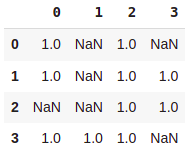
<br>
<br>
[Fig 2: Correct Input]<br>
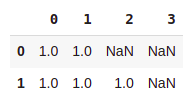
<br>
<br>[Fig 3: Output of Fig 2]<br>
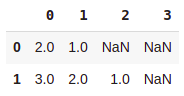

In [107]:
def compute_right_align_mask(eligible_mask):
  output_mask = eligible_mask.rank(method='first',axis=1,ascending=True).rank(axis=1,ascending=False)
  return output_mask

## compute_ranked_prod(_prod,_rank,index_cols=['user_id'])bold text
<table>
  <tr>
    <td><strong>Function Name:</strong></td>
    <td>compute_ranked_prod(_prod,_rank,index_cols=['user_id'])</td>
  </tr>
  <tr>
    <td><strong>Input Parameters:</strong></td>
    <td>
      <table>
        <tr>
          <td> _prod </td>
          <td> Product dataframe where each row represent 1 user. It is possible to have NaN values which indicates the presence of some non eligible products  </td>
        </tr>
        <tr>
          <td> _rank </td>
          <td> Ranking dataframe where each row represent 1 user. It is possible to have NaN values which indicates the presence of some non eligible products. <br>E.g. In [Fig 1], user_id=9997 product A has ranking of 2; product E has ranking of 3; product C has ranking of 1; product D has ranking of 4; In other words, C < A < E < D
          </td>
        </tr>        
      </table>
    </td>
  </tr>
  <tr>
    <td><strong>Outputs:</strong></td>
    <td>
      <table>
        <tr>
          <td> out_df </td>
          <td> This is a dataframe where the columns are the ranking and the values are the product. [Fig 2] is the output of [Fig 1] </td>
        </tr>                
      </table>
    </td>
    <td>    
  </tr> 
</table>

<br>[Fig 1: Sample Input]<br>
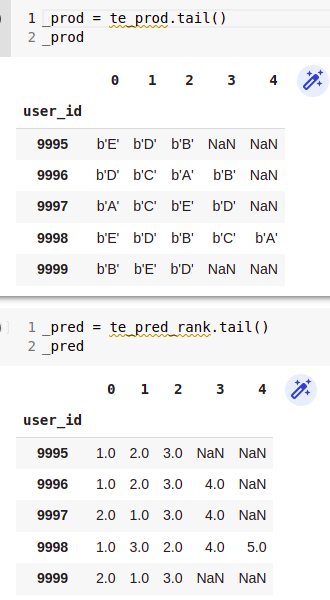
<br>
<br>[Fig 2: Output of Fig 1]<br>
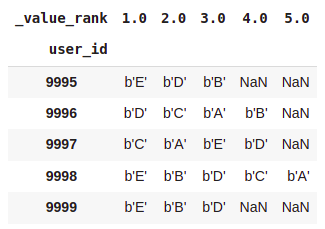

In [127]:
def compute_ranked_prod(_prod,_rank,index_cols=['user_id']):
  den_prod = denom(_prod)
  den_rank = denom(_rank)
  long_data = den_prod.merge(den_rank,on=index_cols + ['_column'],suffixes=('_prod','_rank') )
  long_data.sort_values(index_cols + ['_column'],inplace=True)

  long_data['_value_prod_enc'],_,bw_map = to_int_series(long_data['_value_prod'])
  p1 = long_data.pivot_table(index=index_cols,columns='_value_rank',values='_value_prod_enc' )
  out_df = p1.apply(lambda x: x.map(bw_map)).sort_index(axis=1,ascending=True)
  return out_df


## right_align_df(_df,right_align_mask)
<table>
  <tr>
    <td><strong>Function Name:</strong></td>
    <td>right_align_df(_df,right_align_mask)</td>
  </tr>
  <tr>
    <td><strong>Input Parameters:</strong></td>
    <td>
      <table>
        <tr>
          <td> _df </td>
          <td> Input dataframe to be right aligned. </td>
        </tr>
        <tr>
          <td> right_align_mask </td>
          <td> This is the output of compute_right_align_mask function. </td>
        </tr>        
      </table>
    </td>
  </tr>
  <tr>
    <td><strong>Outputs:</strong></td>
    <td>
      <table>
        <tr>
          <td> out_df </td>
          <td> This is right aligned version of the input matrix. Lets take [Fig 1] as an example: <br></td>
        </tr>               
      </table>
    </td>
    <td>    
  </tr>   
</table>
<br>

[Fig 1]<br>
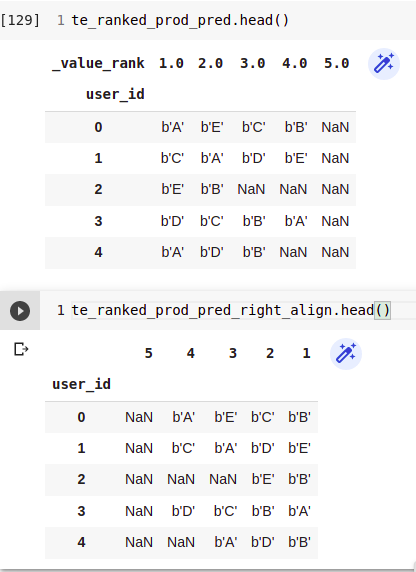

In [128]:
def right_align_df(_df,right_align_mask):
  _max = int(right_align_mask.max().max())
  _min = int(right_align_mask.min().min())

  _,fw_map,bw_map = to_int_series(denom(_df)._value)
  _df2 = _df.apply(lambda x: x.map(fw_map) )

  _df3 = pd.DataFrame({
      i: np.select(
        condlist=[(_df2.values * (right_align_mask==i).values).sum(axis=1) > 0 ],
        choicelist=[(_df2.values * (right_align_mask==i).values).sum(axis=1)],
        default=np.nan
      ) for i in range(_min,_max + 1)
  },index=_df.index).apply(lambda x: x.map(bw_map) )
  out_df = _df3.sort_index(axis=1,ascending=False)
  return out_df


# Test Set Evaluation [Conducted by Data Scientist]

In [101]:
from sklearn.metrics import classification_report,confusion_matrix
te_df = pd.DataFrame([{
    'user_id':i['X_cus'].numpy(),
    'product':i['product'].numpy(),
    '_rank':i['_rank'].numpy(),   
} for i in tfd_tes]).set_index('user_id')
te_prod = te_df['product'].apply(pd.Series).replace(b'<NA>',np.nan)
te_rank = te_df['_rank'].apply(pd.Series).replace(-99.,np.nan)
te_pred = pd.DataFrame(listwise_model.predict(tfd_tes.batch(128)).reshape((-1,5)) ,index=te_df.index) * te_eligible_mask

te_pred_rank = te_pred.rank(method='first',axis=1)

te_eligible_mask = pd.notnull(te_prod).replace(np.nan).astype('int').replace(0,np.nan)
te_right_align_mask = compute_right_align_mask(te_eligible_mask)


te_ranked_prod = compute_ranked_prod(te_prod,te_rank)
te_ranked_prod_pred = compute_ranked_prod(te_prod,te_pred_rank)

te_ranked_prod_right_align = right_align_df(te_ranked_prod,te_right_align_mask)
te_ranked_prod_pred_right_align = right_align_df(te_ranked_prod_pred,te_right_align_mask)




## Top 1 Classification Report

In [132]:
y_true=te_ranked_prod_right_align[1].astype('str').dropna()
y_pred=te_ranked_prod_pred_right_align[1].astype('str').loc[y_true.index]

print('*'*10,'classification report')
print(classification_report(y_true=te_ranked_prod_right_align[1].astype('str'),
                            y_pred=te_ranked_prod_pred_right_align[1].astype('str')))
print('*'*10,'Event Rate')
print((y_true.value_counts() / y_true.value_counts().sum()).sort_index())

********** classification report
              precision    recall  f1-score   support

        b'A'       0.95      0.96      0.96      2041
        b'B'       0.97      0.94      0.95      2247
        b'C'       0.95      0.94      0.95      1202
        b'D'       0.95      0.96      0.96      2093
        b'E'       0.95      0.97      0.96      2417

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

********** Event Rate
b'A'    0.2041
b'B'    0.2247
b'C'    0.1202
b'D'    0.2093
b'E'    0.2417
Name: 1, dtype: float64


Comparing the precisions to the event rates, we see that there are significant lift. The recalls and precisions are high resulting high f1 score.

## Top 2 Classification Report

In [133]:
y_true=te_ranked_prod_right_align[2].astype('str').dropna()
y_pred=te_ranked_prod_pred_right_align[2].astype('str').loc[y_true.index]

print('*'*10,'classification report')
print(classification_report(y_true=te_ranked_prod_right_align[2].astype('str'),
                            y_pred=te_ranked_prod_pred_right_align[2].astype('str')))
print('*'*10,'Event Rate')
print((y_true.value_counts() / y_true.value_counts().sum()).sort_index())

********** classification report
              precision    recall  f1-score   support

        b'A'       0.89      0.88      0.89      1989
        b'B'       0.91      0.91      0.91      2379
        b'C'       0.87      0.88      0.87      1211
        b'D'       0.88      0.89      0.89      2123
        b'E'       0.91      0.90      0.90      2298

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

********** Event Rate
b'A'    0.1989
b'B'    0.2379
b'C'    0.1211
b'D'    0.2123
b'E'    0.2298
Name: 2, dtype: float64


Top 2 also have a slightly poor performance but it still looks good relative to the event rate.

## Exact Matching Product Preference

In [140]:
y_true = te_ranked_prod_right_align.fillna(b'<NA>') 
y_pred = te_ranked_prod_pred_right_align.fillna(b'<NA>') 

(y_true == y_pred).all(axis=1).mean()

0.8311

If we are strict and require full sequence to match, then there is an 83% accuracy.

## All Top 2 Matching Product Preference
Both Top 1 and Top 2 products must equal to be qualified as a "match"

In [142]:
y_true = te_ranked_prod_right_align[[1,2]].fillna(b'<NA>') 
y_pred = te_ranked_prod_pred_right_align[[1,2]].fillna(b'<NA>') 

(y_true == y_pred).all(axis=1).mean()

0.8933

If we only require both top1 and top2 to match, then there is an 89% accuracy.